# Setup

In [51]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    TunedThresholdClassifierCV,
    StratifiedKFold
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier,
    BaggingClassifier
)
from sklearn.metrics import (
    make_scorer, 
    fbeta_score, 
    recall_score,
    accuracy_score,
    confusion_matrix
)

In [52]:
DATA_DIR = '../Dataset/processed'

train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')

# Data preparation

In [53]:
TARGET = 'Machine failure'

In [54]:
features = [f for f in train.columns if f != TARGET]

In [55]:
reduced_features = [f for f in features if f not in 
                    ('Type', 'air_temp_celsius', 'process_temp_celsius', 'power')]

In [56]:
class_ratio = train[TARGET].value_counts()[0] / train[TARGET].value_counts()[1]

# Modeling framework

In [57]:
def fit_model(classifier, feature_set):
    fbeta = make_scorer(fbeta_score, beta=2)
    skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=0)
    # no scaling needed for tree-based models
    model_pipeline = make_pipeline(classifier)

    tuned_model = TunedThresholdClassifierCV(
        estimator=model_pipeline,
        scoring=fbeta,
        response_method='auto',
        thresholds=100,
        cv=skf,
        refit=True,
        n_jobs=-1,
        random_state=0
    ).fit(train[feature_set], train[TARGET])

    return tuned_model

In [58]:
def evaluate_model(model, feature_set):
    predictions = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], predictions)
    recall = recall_score(test[TARGET], predictions)
    f2 = fbeta_score(test[TARGET], predictions, beta=2)
    print(f'Accuracy: {accuracy:.4f}\nF2-score: {f2:.4f}\nRecall:   {recall:.4f}\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], predictions, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()

In [59]:
def save_model(model, model_config, notebook='04'):
    MODEL_DIR = 'saved_models'
    save_path = f'{MODEL_DIR}/{notebook}_{model_config}.joblib'
    joblib.dump(model, save_path)

# Random Forest

In [60]:
classifier = RandomForestClassifier(
    n_estimators=100, max_depth=6, n_jobs=1, random_state=0)

**All features**

Accuracy: 0.9850
F2-score: 0.8092
Recall:   0.8235



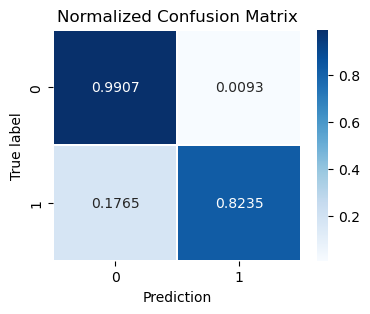

In [61]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'randomforest-all_features')

**Reduced features**

Accuracy: 0.9840
F2-score: 0.8046
Recall:   0.8235



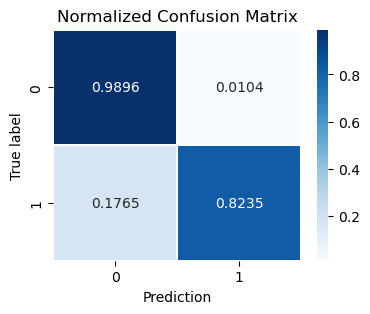

In [62]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'randomforest-reduced_features')

# Extra Trees

In [63]:
classifier = ExtraTreesClassifier(
    n_estimators=100, max_depth=5, n_jobs=1, random_state=0)

**All features**

Accuracy: 0.9810
F2-score: 0.7714
Recall:   0.7941



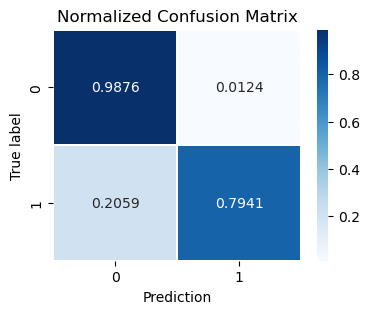

In [64]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'extratrees-all_features')

**Reduced features**

Accuracy: 0.9830
F2-score: 0.7803
Recall:   0.7941



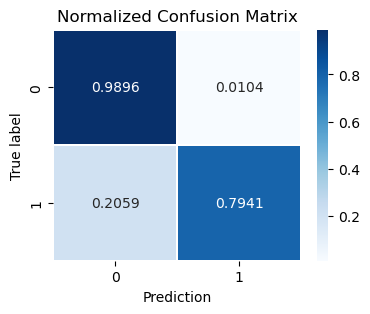

In [65]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'extratrees-reduced_features')

# Bagging Classifier

In [81]:
estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
classifier = BaggingClassifier(
    estimator=estimator, n_estimators=10, n_jobs=1, random_state=0)

**All features**

Accuracy: 0.9900
F2-score: 0.8333
Recall:   0.8235



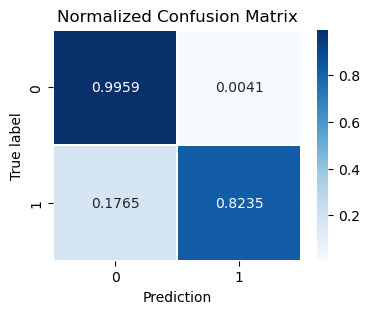

In [82]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'bagging-all_features')

**Reduced features**

Accuracy: 0.9850
F2-score: 0.8092
Recall:   0.8235



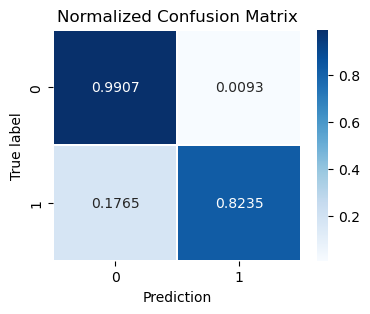

In [83]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'bagging-reduced_features')